In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
from bs4 import BeautifulSoup
import json
import numpy as np

In [2]:
with open("/content/drive/MyDrive/Sarcasm-Detector/Sarcasm.json",'r') as input:
  data = json.load(input)
print(len(data))

26709


In [3]:
## Use NLTK's Stopword List
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
sarcasm_sentences = []
labels = []
links = []
punctuations = str.maketrans('', '', string.punctuation)
for item in data:
  sentence = item['headline'].lower()
  sentence = sentence.replace(",", " , ").replace(".", " . ").replace("-", " - ").replace("/", " / ")
  sentence = BeautifulSoup(sentence, "html.parser").get_text()

  words = sentence.split()
  filtered_sentence = ""

  for word in words:
    word = word.translate(punctuations)
    if word not in stopwords:
      filtered_sentence += word + " "
  sarcasm_sentences.append(filtered_sentence)
  labels.append(item['is_sarcastic'])
  links.append(item['article_link'])

In [5]:
print(len(sarcasm_sentences))

26709


In [6]:
training_size = 20000
vocab_size = 20000
maxlen = 40
training_sentences = sarcasm_sentences[0:training_size]
training_labels = labels[0:training_size]
testing_sentences = sarcasm_sentences[training_size:]
testing_labels = labels[training_size:]

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequence, maxlen=maxlen, padding='post', truncating='post')
testing_sequence = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequence, maxlen=maxlen, padding='post', truncating='post')

In [8]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels).astype(np.float32).reshape(-1)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels).astype(np.float32).reshape(-1)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',   # You can also monitor 'val_accuracy'
    patience=10,           # Stop after 10 epochs of no improvement
    restore_best_weights=True
)


In [10]:
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(input_dim=20000, output_dim=64, input_length=maxlen),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )
model.build(input_shape=(None, maxlen))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 64)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,350,209 (5.15 MB)

 Trainable params: 1,350,209 (5.15 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stop],
                    batch_size=32
                  )

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6868 - loss: 0.5615 - val_accuracy: 0.8144 - val_loss: 0.4116
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9176 - loss: 0.2068 - val_accuracy: 0.8031 - val_loss: 0.4517
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9692 - loss: 0.0898 - val_accuracy: 0.7895 - val_loss: 0.6766
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9845 - loss: 0.0434 - val_accuracy: 0.7842 - val_loss: 0.7653
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9935 - loss: 0.0207 - val_accuracy: 0.7836 - val_loss: 0.9910
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9970 - loss: 0.0107 - val_accuracy: 0.7860 - val_loss: 1.1333
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9978 - loss: 0.0072 - val_accuracy: 0.7825 - val_loss: 1.2473
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9983 - loss: 0.0066 - val_accura

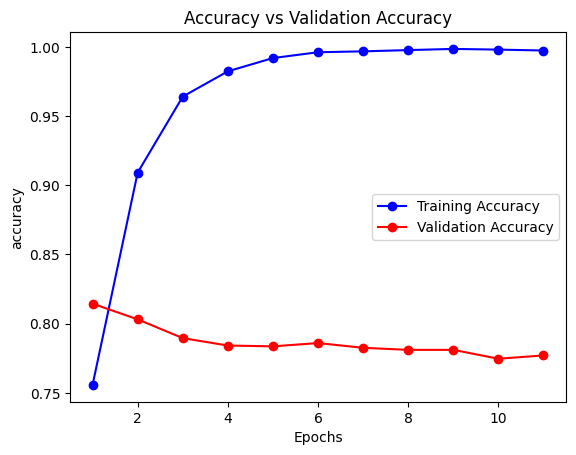

In [12]:
## plotting accuracy vs validation accuracy
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
  plt.title("Accuracy vs Validation Accuracy")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.show()
plot_accuracy(history)

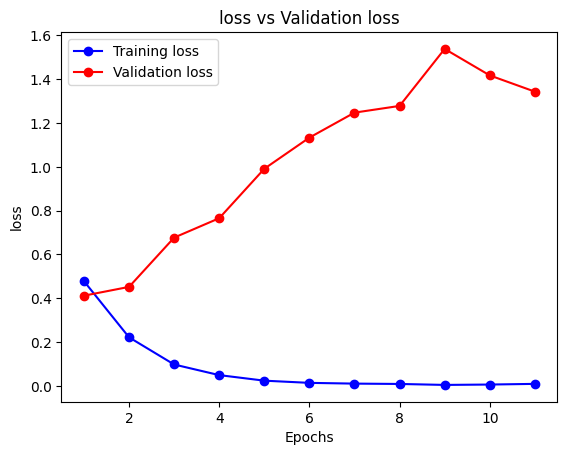

In [13]:
## plotting loss vs validation loss
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['loss']
  val_accuracy = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training loss')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation loss')
  plt.title("loss vs Validation loss")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.show()
plot_accuracy(history)

## Reducing Overfitting in Language Models

In [14]:
## Adjusting the learning rate
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.00001,beta_1=0.90, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )
history1 = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stop],
                    batch_size=32
                  )

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9344 - loss: 0.1936 - val_accuracy: 0.8116 - val_loss: 0.4270
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9322 - loss: 0.1848 - val_accuracy: 0.8107 - val_loss: 0.4377
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9354 - loss: 0.1753 - val_accuracy: 0.8116 - val_loss: 0.4455
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9343 - loss: 0.1772 - val_accuracy: 0.8128 - val_loss: 0.4508
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9405 - loss: 0.1642 - val_accuracy: 0.8128 - val_loss: 0.4556
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9349 - loss: 0.1730 - val_accuracy: 0.8147 - val_loss: 0.4603
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9394 - loss: 0.1641 - val_accuracy: 0.8149 - val_loss: 0.4644
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9415 - loss: 0.1596 - val_acc

In [15]:
## Exploring embedding dimensions
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(input_dim=20000, output_dim=32, input_length=maxlen),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001,beta_1=0.90, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )

history2 = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stop],
                    batch_size=32
                  )

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5684 - loss: 0.6827 - val_accuracy: 0.6995 - val_loss: 0.6109
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7513 - loss: 0.5202 - val_accuracy: 0.7846 - val_loss: 0.4651
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8599 - loss: 0.3246 - val_accuracy: 0.7873 - val_loss: 0.4640
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9027 - loss: 0.2419 - val_accuracy: 0.8025 - val_loss: 0.4447
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9243 - loss: 0.1965 - val_accuracy: 0.7991 - val_loss: 0.4922
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9464 - loss: 0.1476 - val_accuracy: 0.7973 - val_loss: 0.5064
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9592 - loss: 0.1193 - val_accuracy: 0.7951 - val_loss: 0.5743
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9685 - loss: 0.0994 - val_acc

In [16]:
## Using Dropout
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(input_dim=20000, output_dim=32, input_length=maxlen),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
          tf.keras.layers.Dropout(.25),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dropout(.25),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001,beta_1=0.90, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )

history3 = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stop],
                    batch_size=32
                  )

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5590 - loss: 0.6849 - val_accuracy: 0.6752 - val_loss: 0.6418
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7182 - loss: 0.5754 - val_accuracy: 0.7846 - val_loss: 0.4662
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8456 - loss: 0.3679 - val_accuracy: 0.7974 - val_loss: 0.4407
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8906 - loss: 0.2773 - val_accuracy: 0.7939 - val_loss: 0.4637
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9178 - loss: 0.2175 - val_accuracy: 0.7991 - val_loss: 0.4808
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9384 - loss: 0.1677 - val_accuracy: 0.7936 - val_loss: 0.5027
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9533 - loss: 0.1391 - val_accuracy: 0.7933 - val_loss: 0.5570
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9668 - loss: 0.1065 - val_a

In [17]:
## Using regularization
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(input_dim=20000, output_dim=32, input_length=maxlen),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
          tf.keras.layers.Dropout(.3),
          tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          tf.keras.layers.Dropout(.3),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001,beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )
history4 = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stop],
                    batch_size=32
                  )

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5614 - loss: 1.1044 - val_accuracy: 0.5633 - val_loss: 0.8732
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5800 - loss: 0.8266 - val_accuracy: 0.7123 - val_loss: 0.6677
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7626 - loss: 0.5886 - val_accuracy: 0.7681 - val_loss: 0.5335
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8581 - loss: 0.3963 - val_accuracy: 0.7956 - val_loss: 0.4809
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8923 - loss: 0.3171 - val_accuracy: 0.7961 - val_loss: 0.4808
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9163 - loss: 0.2664 - val_accuracy: 0.7962 - val_loss: 0.5104
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9323 - loss: 0.2201 - val_accuracy: 0.7948 - val_loss: 0.5051
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9420 - loss: 0.1947 - val_acc

In [20]:
## Other improvement
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=20000, output_dim=64, input_length=maxlen),
    tf.keras.layers.SpatialDropout1D(0.3),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),

    tf.keras.layers.GlobalMaxPooling1D(),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999),
    metrics=['accuracy']
)

history5 = model.fit(
    training_padded, training_labels,
    epochs=30,
    validation_data=(testing_padded, testing_labels),
    callbacks=[early_stop],
    batch_size=32
)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.5071 - loss: 1.2548 - val_accuracy: 0.7092 - val_loss: 0.9649
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7460 - loss: 0.8437 - val_accuracy: 0.7860 - val_loss: 0.6480
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8502 - loss: 0.5479 - val_accuracy: 0.8000 - val_loss: 0.5462
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8870 - loss: 0.4149 - val_accuracy: 0.7958 - val_loss: 0.5211
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9131 - loss: 0.3419 - val_accuracy: 0.7983 - val_loss: 0.5195
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9344 - loss: 0.2868 - val_accuracy: 0.7882 - val_loss: 0.5486
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9417 - loss: 0.2659 - val_accuracy: 0.7946 - val_loss: 0.5269
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9509 - loss: 0.2421 - v

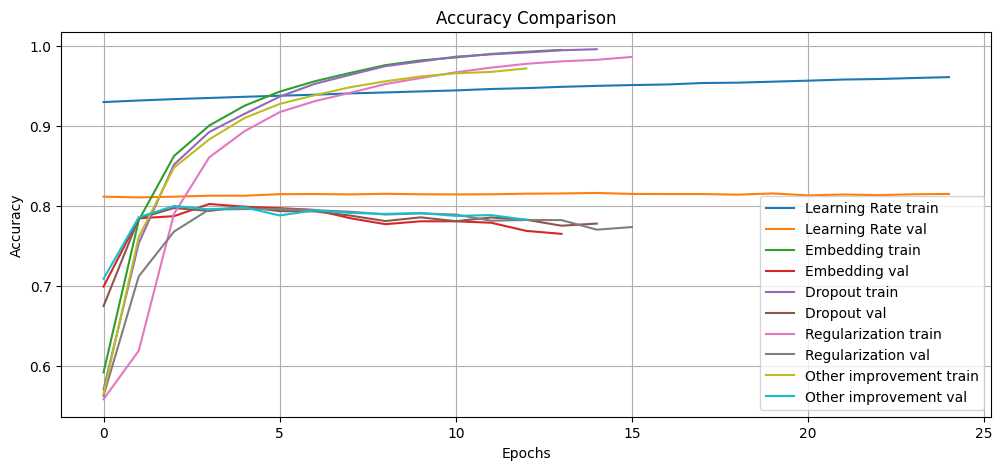

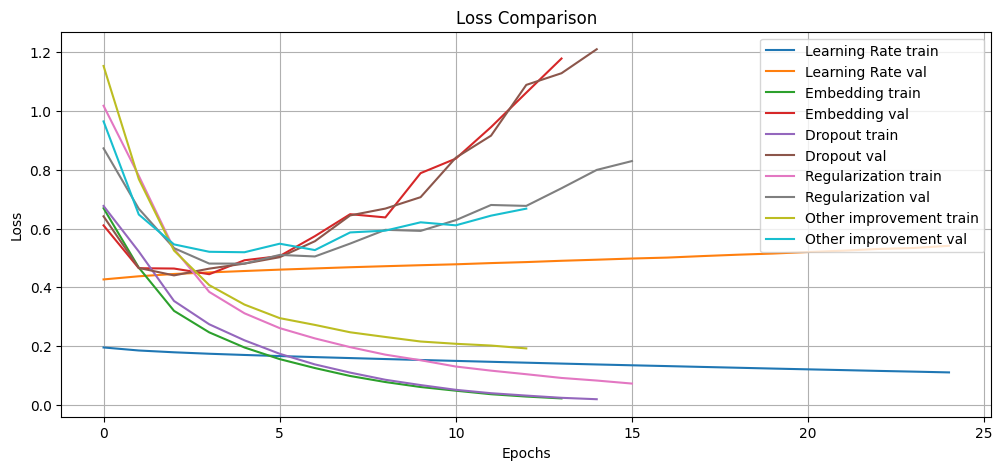

In [21]:
def plot_history(histories, metric='accuracy'):
    plt.figure(figsize=(12, 5))
    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} train')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} val')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.title(f'{metric.capitalize()} Comparison')
    plt.grid(True)
    plt.show()

histories = {
    'Learning Rate': history1,
    'Embedding': history2,
    'Dropout': history3,
    'Regularization': history4,
    'Other improvement': history5
}
plot_history(histories, 'accuracy')
plot_history(histories, 'loss')


## Making Prediction

In [22]:
sarcastic_sentences = [
    "Oh great, another Monday morning. Just what I needed.",
    "I absolutely love when my phone dies in the middle of an important call.",
    "Sure, I’d love to work overtime this weekend—for free.",
    "Because nothing screams fun like standing in line at the DMV.",
    "Of course the printer stops working right before the deadline.",
    "Wow, my internet just got slower—what a dream come true.",
    "Yay, traffic again! I was hoping I'd spend an hour going five miles.",
    "I totally didn't need sleep last night, thanks for asking.",
    "Love when the coffee machine breaks down at 8 a.m.",
    "Oh fantastic, spilled coffee on my shirt right before the meeting."
]

In [23]:
sequences1 = tokenizer.texts_to_sequences(sarcastic_sentences)
padded1 = pad_sequences(sequences1, maxlen=maxlen, padding="post", truncating="post")
print(model.predict(padded1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
[[0.60857034]
 [0.38339722]
 [0.45885438]
 [0.9572686 ]
 [0.71128935]
 [0.1867    ]
 [0.9433339 ]
 [0.25008494]
 [0.69736093]
 [0.84461635]]


In [24]:
non_sarcastic_sentences = [
    "The sky was clear and the weather was perfect for a walk.",
    "She enjoys reading historical fiction in her free time.",
    "He just started a new job as a software engineer.",
    "Granny baked cookies for the whole family.",
    "They are planning a trip to the mountains this winter.",
    "The team celebrated their victory with a party.",
    "The new restaurant downtown serves delicious sushi.",
    "I finally finished my TensorFlow project last night.",
    "They planted tomatoes and peppers in the garden.",
    "The dog wagged its tail when I came home."
]

In [25]:
sequences2 = tokenizer.texts_to_sequences(non_sarcastic_sentences)
padded2 = pad_sequences(sequences2, maxlen=maxlen, padding="post", truncating="post")
print(model.predict(padded2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0.5999548 ]
 [0.9439376 ]
 [0.931978  ]
 [0.47737777]
 [0.64991194]
 [0.45776263]
 [0.4264501 ]
 [0.8031321 ]
 [0.71446717]
 [0.35558724]]


In [26]:
from keras.saving import save_model
save_model(model, '/content/drive/MyDrive/Sarcasm-Detector/sarcasm.keras')